# Thin-Film Structure Optimization with Bayesian Optimization

This example shows the application of JaxLayerLumos to thin-film structure optimization using Bayesian optimization. In this example, we use [BayesO](https://github.com/jungtaekkim/bayeso) [1].

[1] Jungtaek Kim and Seungjin Choi. [BayesO: A Bayesian optimization framework in Python](https://doi.org/10.21105/joss.05320). *Journal of Open Source Software*, vol. 8, no. 90, p. 5320, 2023.

Some required packages are imported first.

In [1]:
import jax
import jax.numpy as jnp
import numpy as onp
import matplotlib.pyplot as plt
from bayeso.bo import bo_w_gp

import jaxlayerlumos as jll
import jaxlayerlumos.utils_materials as jll_utils_materials
import jaxlayerlumos.utils_spectra as jll_utils_spectra
import jaxlayerlumos.utils_units as jll_utils_units

We define a three-layer structure with TiO$_2$/Ag/TiO$_2$ for reflection.

In addition, a random seed, the number of initial points, the number of iterations, and a thickness range for structure optimization are declared. In particular, `bound_thickness` is in nanometers.

In [2]:
str_mode = "reflection"
materials = ["Air", "TiO2", "Ag", "TiO2", "FusedSilica"]
num_layers = len(materials) - 2
bound_thickness = onp.array([0.0, 100.0])

seed = 42
num_init = 10
num_iter = 100

In the next cell, frequencies, wavelengths, and wavelengths in nanometers are defined, and the $n$ and $k$ values of the structure are obtained from our software.

In [3]:
frequencies = jll_utils_spectra.get_frequencies_visible_light()
wavelengths = jll_utils_spectra.convert_frequencies_to_wavelengths(frequencies)
wavelengths_in_nm = wavelengths / jll_utils_units.get_nano()

n_k = jll_utils_materials.get_n_k(materials, frequencies)

print(f"frequencies.shape {frequencies.shape}")
print(f"wavelengths.shape {wavelengths.shape}")
print(f"wavelengths_in_nm.shape {wavelengths_in_nm.shape}")
print(f"n_k.shape {n_k.shape}")

frequencies.shape (1001,)
wavelengths.shape (1001,)
wavelengths_in_nm.shape (1001,)
n_k.shape (1001, 5)


We choose a simple target spectrum over the frequencies of interest.

In [4]:
target_spectrum = jnp.zeros_like(frequencies)
target_spectrum = target_spectrum.at[:200].set(0.2)
target_spectrum = target_spectrum.at[700:].set(0.2)

We plot the target spectrum.

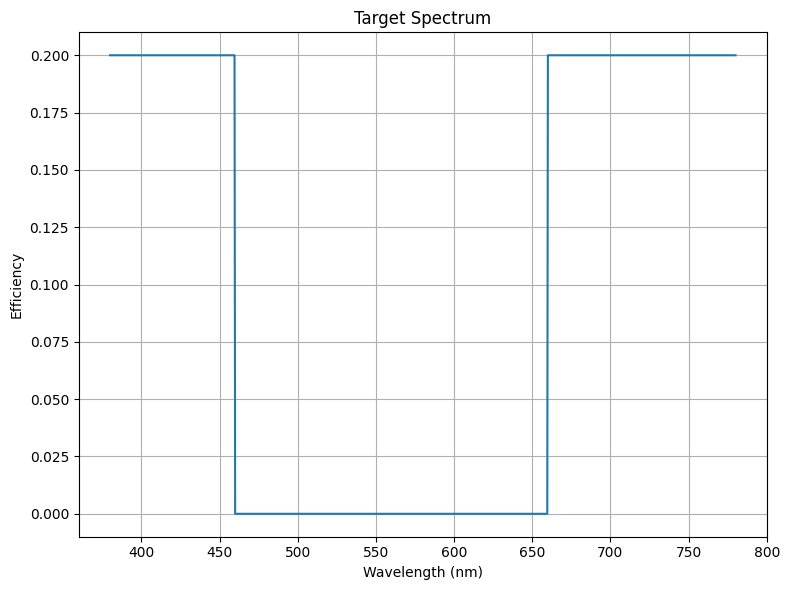

In [5]:
fig = plt.figure(figsize=(8, 6))
ax = fig.gca()

ax.plot(wavelengths_in_nm, target_spectrum)

ax.set_title(f"Target Spectrum")

ax.set_xlabel("Wavelength (nm)")
ax.set_ylabel("Efficiency")
ax.grid()

plt.tight_layout()
plt.show()

`transform` is to clip thicknesses to non-negative values, concatenate 0 into the beginning and end of the thicknesses, and multiply 10$^{-9}$ to the thicknesses.

`get_spectrum` is to calculate the transmission or reflection spectrum of a thin-film structure with thicknesses at a normal angle.

`objective` defines a squared residual between the target spectrum and the spectrum of the current structure.

In [6]:
def transform(inputs):
    thicknesses = jnp.clip(inputs, min=0)
    thicknesses = jnp.concatenate([
        jnp.array([0]),
        thicknesses,
        jnp.array([0])
    ], axis=0)
    thicknesses *= jll_utils_units.get_nano()

    return thicknesses

def get_spectrum(inputs):
    angles = jnp.array([0.0])
    thicknesses = transform(inputs)

    R_TE, T_TE, R_TM, T_TM = jll.stackrt(n_k, thicknesses, frequencies, thetas=angles)

    R_TE = R_TE[0]
    T_TE = T_TE[0]
    R_TM = R_TM[0]
    T_TM = T_TM[0]

    if str_mode == "transmission":
        spectrum = (T_TE + T_TM) / 2
    elif str_mode == "reflection":
        spectrum = (R_TE + R_TM) / 2
    else:
        raise ValueError

    return spectrum

def objective(inputs, target_spectrum):
    inputs = jnp.array(inputs)

    spectrum = get_spectrum(inputs)
    loss = jnp.sum(jnp.abs(spectrum - target_spectrum)**2)
    loss = float(loss)

    return loss

The initial thicknesses are set by sampling `num_init` points from a uniform distribution $\mathcal{U}(0, 100)$. Note that they are in nanometers.

Then, we evaluate the `num_init` points using an objective function `fun_objective`. This objective should be minimized.

In [7]:
params = jax.random.uniform(jax.random.key(seed), shape=(num_init, num_layers), minval=bound_thickness[0], maxval=bound_thickness[1])
parameters = onp.array(params)

fun_objective = lambda inputs: objective(inputs, target_spectrum)
loss_values = []

for param in parameters:
    loss_values.append([fun_objective(param)])

loss_values = onp.array(loss_values)

print(f'parameters.shape {parameters.shape}')
print(f'loss_values.shape {loss_values.shape}')

parameters.shape (10, 3)
loss_values.shape (10, 1)


The next cell carries out the structure optimization using Bayesian optimization with Gaussian processes and an expected improvement acquisition function for `num_iter` iterations.

In [8]:
model_bo = bo_w_gp.BOwGP(
    onp.tile(bound_thickness[onp.newaxis, ...], (num_layers, 1)),
    str_acq='ei',
    normalize_Y=True,
    debug=False
)

for ind in range(0, num_iter):
    next_x, _ = model_bo.optimize(parameters, loss_values, seed=(ind + seed) * seed, str_sampling_method='uniform')
    loss_value = fun_objective(next_x)

    parameters = onp.concatenate([parameters, [next_x]], axis=0)
    loss_values = onp.concatenate([loss_values, [[loss_value]]], axis=0)

    print(f"Iteration {ind + 1}: {loss_value:.8f}")

Iteration 1: 616.21741293
Iteration 2: 483.10197540
Iteration 3: 558.74160328
Iteration 4: 492.36337340
Iteration 5: 354.88793723
Iteration 6: 657.25913697
Iteration 7: 685.74127741
Iteration 8: 680.19201181
Iteration 9: 32.59617134
Iteration 10: 18.16025673
Iteration 11: 623.05430029
Iteration 12: 453.96122008
Iteration 13: 7.28880733
Iteration 14: 46.65720098
Iteration 15: 109.35279784
Iteration 16: 600.34825590
Iteration 17: 328.63167434
Iteration 18: 172.78538552
Iteration 19: 187.11884716
Iteration 20: 382.48504429
Iteration 21: 688.19457811
Iteration 22: 696.30918409
Iteration 23: 502.01421164
Iteration 24: 68.87787191
Iteration 25: 488.94096986
Iteration 26: 195.01529155
Iteration 27: 626.60394081
Iteration 28: 704.07913297
Iteration 29: 569.62943249
Iteration 30: 705.58887933
Iteration 31: 579.29420656
Iteration 32: 51.97399834
Iteration 33: 33.22475973
Iteration 34: 21.86685027
Iteration 35: 18.44683455
Iteration 36: 712.63130069
Iteration 37: 461.69113945
Iteration 38: 342.24

We print the thicknesses found by this example and calculate the spectrum of the structure with the optimized thicknesses.

In [9]:
ind_thicknesses_optimized = onp.argmin(loss_values[:, 0])
thicknesses_optimized = parameters[ind_thicknesses_optimized]

for material, thickness in zip(materials, thicknesses_optimized):
    print(f'{material} {thickness:.2f} nm')

spectrum_optimized = get_spectrum(thicknesses_optimized)

Air 31.08 nm
TiO2 9.26 nm
Ag 96.21 nm


Finally, we plot the spectrum we get through the structure optimization, as well as the target spectrum.

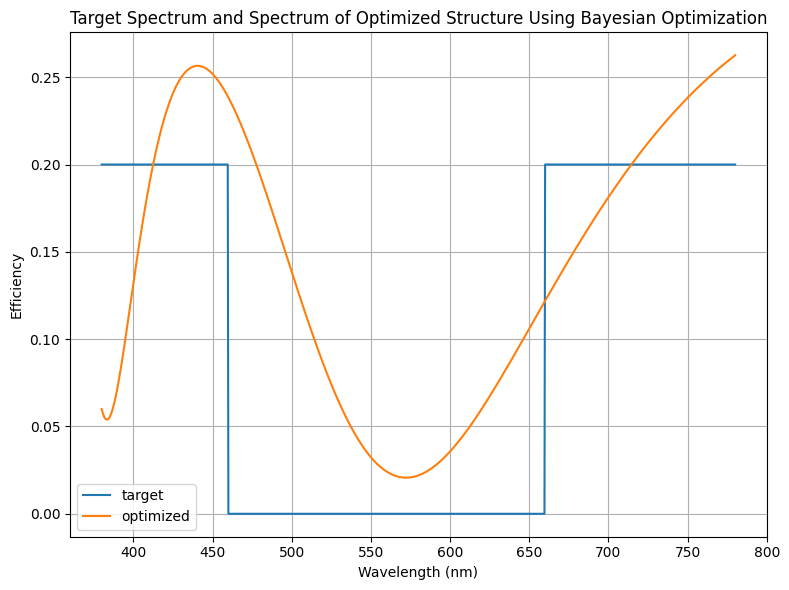

In [10]:
fig = plt.figure(figsize=(8, 6))
ax = fig.gca()

ax.plot(wavelengths_in_nm, target_spectrum, label='target')
ax.plot(wavelengths_in_nm, spectrum_optimized, label='optimized')

ax.set_title(f"Target Spectrum and Spectrum of Optimized Structure Using Bayesian Optimization")

ax.set_xlabel("Wavelength (nm)")
ax.set_ylabel("Efficiency")
ax.grid()

plt.legend()
plt.tight_layout()
plt.show()